In [9]:
import os
import subprocess
import numpy as np
from Tools.evalute_model import *

In [14]:
train_x_file_path='Parabel/dataset/train_feat.txt'
train_y_file_path='Parabel/dataset/train_label.txt'

test_x_file_path='Parabel/dataset/test_feat.txt'
test_y_file_path='Parabel/dataset/test_label.txt'

model_dir='Parabel/output'
pred_y_file_path='Parabel/output/output_scores.txt'

masked_train_x_file_path='Parabel/dataset/masked_train_feat.txt'
masked_test_x_file_path='Parabel/dataset/masked_test_feat.txt'
model_masked_dir='Parabel/output_masked'

base_pred_y_mask_file_path='Parabel/output_masked/base_output_scores.txt'
pred_y_masked_file_path='Parabel/output_masked/output_scores.txt'


In [3]:
def load_parabel_sparse_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    shape_line = lines[0]
    num_rows, num_cols = map(int, shape_line.strip().split())

    data = []
    row_idx = []
    col_idx = []

    for i, line in enumerate(lines[1:]):
        tokens = line.strip().split()
        for tok in tokens:
            if ":" in tok:
                col, val = tok.split(":")
                col = int(col)
                val = float(val)
                row_idx.append(i)
                col_idx.append(col)
                data.append(val)
    return (np.array(data), np.array(row_idx), np.array(col_idx), (num_rows, num_cols))



def save_parabel_sparse_file(data, row_idx, col_idx, shape, file_path):
    from collections import defaultdict
    row_data = defaultdict(list)
    for val, row, col in zip(data, row_idx, col_idx):
        row_data[row].append((col, val))

    with open(file_path, 'w') as f:
        f.write(f"{shape[0]} {shape[1]}\n")
        for i in range(shape[0]):
            entries = row_data[i]
            entries.sort()  # sort by column index
            line = " ".join([f"{col}:{val:.6f}" for col, val in entries])
            f.write(line + "\n")

In [ ]:
def random_feature_masking(data, drop_prob=0.2):
    mask = np.random.rand(len(data)) > drop_prob
    return data * mask

In [13]:
x_test_data, x_test_row, x_test_col, shape = load_parabel_sparse_file(test_x_file_path)
x_test_data_masked = random_feature_masking(x_test_data, drop_prob=0.2)
save_parabel_sparse_file(x_test_data_masked, x_test_row, x_test_col, shape, masked_test_x_file_path)


In [15]:
# testing the model
command = [
    "./Parabel/binaries/Linux/parabel_predict",     # Ensure binary is compiled and accessible
    masked_test_x_file_path,
    model_dir,
    base_pred_y_mask_file_path,
    "-T", "4",               # Number of threads
    "-s", "0",               # Start tree
    "-t", "3",               # Number of trees
    "-B", "10",              # Beam width
    "-q", "0"                # Verbosity
]

test_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(test_result.stdout)
print("Testing complete")

tree 2 predicting started
tree 0 predicting started
tree 1 predicting started
node 0
node 0
node 0
node 100
node 100
node 100
tree 0 predicting completed
tree 2 predicting completed
tree 1 predicting completed
prediction time: 1.26331 ms/point
model size: 0.0259221 GB

Testing complete


In [24]:
avg_precision_base, avg_ndcg_base = evaluate_metrics(test_y_file_path, base_pred_y_mask_file_path)


print("Evaluation Metrics (k = 1 to 10):\n")
print(f"{'k':<4} {'Precision@k':<10} {'nDCG@k':<10}")
print("-" * 34)

for k in range(1, 11):
    print(f"{k:<4} {avg_precision_base[k]*100:<10.2f} {avg_ndcg_base[k]*100:<10.2f}")

Evaluation Metrics (k = 1 to 10):

k    Precision@k nDCG@k    
----------------------------------
1    77.87      77.87     
2    70.57      72.24     
3    64.30      67.74     
4    58.55      64.19     
5    53.34      62.06     
6    48.51      61.44     
7    44.21      62.84     
8    40.50      64.07     
9    37.33      65.12     
10   34.57      65.98     


In [ ]:
x_train_data, x_train_row, x_train_col, shape = load_parabel_sparse_file(train_x_file_path)
x_train_data_masked = random_feature_masking(x_train_data, drop_prob=0.2)
save_parabel_sparse_file(x_train_data_masked, x_train_row, x_train_col, shape, masked_train_x_file_path)


In [6]:
# training the model
if not os.path.exists(model_masked_dir):
    os.makedirs(model_masked_dir)

command = [
    "./Parabel/binaries/Linux/parabel_train",
    masked_train_x_file_path,
    train_y_file_path,
    model_masked_dir,
    "-T", "4",        # Number of threads
    "-s", "0",        # Start tree
    "-t", "3",        # Number of trees
    "-b", "1.0",      # Bias
    "-c", "1.0",      # Classifier cost
    "-m", "100",      # Max leaf size
    "-tcl", "0.1",    # Classifier threshold
    "-tce", "0",      # Centroid threshold
    "-e", "0.0001",   # Clustering eps
    "-n", "20",       # Max iterations
    "-k", "0",        # Classifier kind
    "-q", "0"         # Verbosity
]



train_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(train_result.stdout)
print("Training complete")

tree 0 training started
tree 0 training started
tree 1 training started
tree 2 training started
node 0
node 0
node 0
node 100
node 100
node 100
tree 1 training completed
tree 0 training completed
tree 2 training completed
Training time: 0.0200628 hr

Training complete


In [21]:
# testing the model
command = [
    "./Parabel/binaries/Linux/parabel_predict",     # Ensure binary is compiled and accessible
    masked_test_x_file_path,
    model_masked_dir,
    pred_y_masked_file_path,
    "-T", "4",               # Number of threads
    "-s", "0",               # Start tree
    "-t", "3",               # Number of trees
    "-B", "10",              # Beam width
    "-q", "0"                # Verbosity
]

test_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(test_result.stdout)
print("Testing complete")

tree tree 1 predicting startedtree d
2 predicting started
tree tree 1 predicting startedtree d
2 predicting started
tree tree 1 predicting startedtree d
2 predicting started
node 0
node 0
node 0
node 100
node 100
node 100
tree 2 predicting completed
tree 0 predicting completed
tree 1 predicting completed
prediction time: 1.256 ms/point
model size: 0.0275781 GB

Testing complete


In [26]:
# +4
avg_precision, avg_ndcg = evaluate_metrics(test_y_file_path, pred_y_masked_file_path)


print("Evaluation Metrics (k = 1 to 10):\n")
print(f"{'k':<4} {'Precision@k':<10} {'nDCG@k':<10}")
print("-" * 34)

for k in range(1, 11):
    print(f"{k:<4} {avg_precision[k]*100:<10.2f} {avg_ndcg[k]*100:<10.2f}")

Evaluation Metrics (k = 1 to 10):

k    Precision@k nDCG@k    
----------------------------------
1    81.29      81.29     
2    74.20      75.82     
3    68.16      71.51     
4    62.25      67.88     
5    56.84      65.59     
6    51.97      64.91     
7    47.86      66.41     
8    44.20      67.66     
9    41.03      68.68     
10   38.35      69.58     


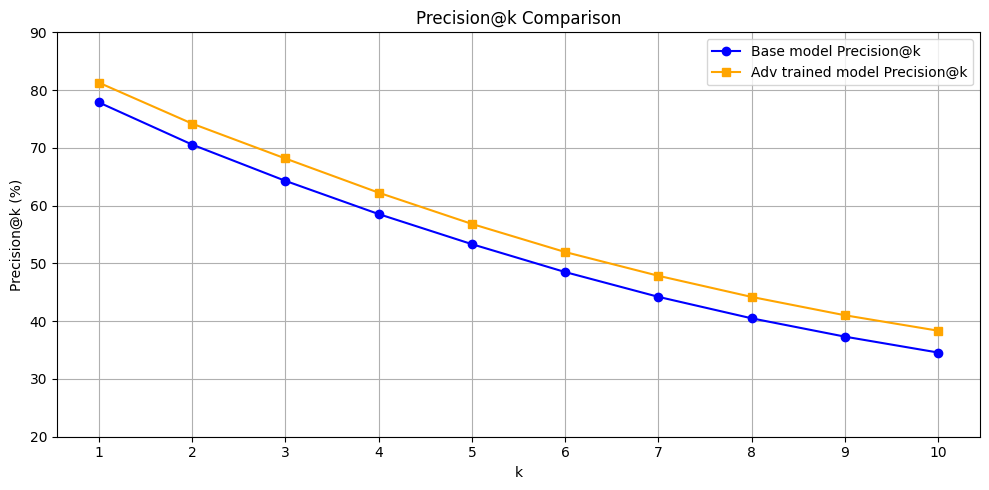

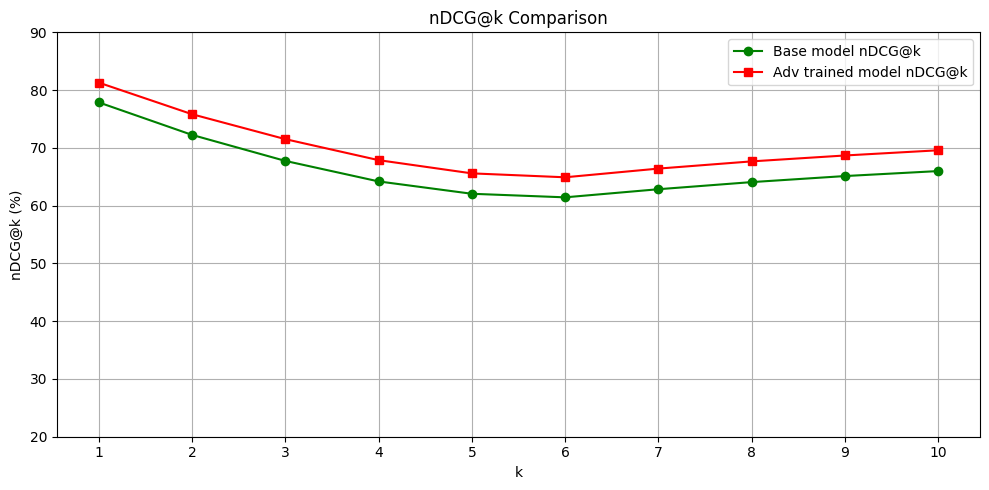

In [29]:
import matplotlib.pyplot as plt

base_precision_list = [avg_precision_base[k]*100 for k in range(1, 11)]
base_ndcg_list = [avg_ndcg_base[k]*100 for k in range(1, 11)]

# Adv model metrics
adv_precision = [avg_precision[k] * 100 for k in range(1, 11)]
adv_ndcg = [avg_ndcg[k]*100 for k in range(1, 11)]

k_values = list(range(1, 11))

# Precision@k Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, base_precision_list, marker='o', label='Base model Precision@k', color='blue')
plt.plot(k_values, adv_precision, marker='s', label='Adv trained model Precision@k', color='orange')
plt.xlabel('k')
plt.ylabel('Precision@k (%)')
plt.title('Precision@k Comparison')
plt.xticks(k_values)
plt.grid(True)
plt.ylim(20, 90)

plt.legend()
plt.tight_layout()
plt.show()


# nDCG@k Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, base_ndcg_list, marker='o', label='Base model nDCG@k', color='green')
plt.plot(k_values, adv_ndcg, marker='s', label='Adv trained model nDCG@k', color='red')
plt.xlabel('k')
plt.ylabel('nDCG@k (%)')
plt.title('nDCG@k Comparison')
plt.xticks(k_values)
plt.grid(True)
plt.ylim(20, 90)

plt.legend()
plt.tight_layout()
plt.show()